## Configuration

In [1]:
import sys
import os

model_name = 'exp-7-v2.pkl'
SEED = 42
VAL_PCT = 0.2
INFER = False
DEBUG = False
VIZ = False

GRADIENT = os.path.exists('train')
KAGGLE = os.path.exists('../input')

if KAGGLE:
    !mkdir -p uwmadisonutils
    !cp ../input/uw-madison-models/*.py uwmadisonutils/
    !cp -r ../input/pytorch-segmentation-models-lib/ ./
    !pip install -q ./pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
    !pip install -q ./pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
    !pip install -q ./pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
    !pip install -q ./pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl


if KAGGLE:
    sys.path.insert(0, '../input/uwmadisonutils/')
    data_path = '../input/uw-madison-gi-tract-image-segmentation/'
    model_name = '../input/uw-madison-models/' + model_name
    
elif GRADIENT:
    sys.path.insert(0, 'uwmadisonutils/')
    data_path = ''
    model_name = 'uwmadisonutils/' + model_name 

from uwmadisonutils.utilities import *

## Libraries and Data

In [2]:
path = Path(data_path+'train')
test_path = Path(data_path+'test')

train = pd.read_csv(data_path+'train.csv', low_memory=False)
sample_submission = pd.read_csv(data_path+'sample_submission.csv', low_memory=False).rename(columns={'predicted': 'segmentation'})

train_path = Path(data_path+'train')
test_path = Path(data_path+'test')

train_fnames = get_image_files(train_path)
test_fnames = get_image_files(test_path)

## Prepare Data

In [3]:
if sample_submission.shape[0] > 0: 
    test = sample_submission.copy()
else:
    test_fnames = train_fnames
    test_path = train_path
    test = train.copy()
    test = test.sample(frac=1.0, random_state=SEED)

test = get_custom_df(test, test_fnames, str(test_path), channels=3, stride=2)
train = get_custom_df(train, train_fnames, str(train_path), channels=3, stride=2)

In [4]:
if DEBUG:
    test = test.iloc[:1000]
    test_fnames = test_fnames[:1000]

## Learner

## TTA

In [5]:
def get_test_aug(img_size, resize=0.5, crop=0.9):
    crop_size = [round(crop*size) for size in img_size]
    resize = [round(resize*size) for size in crop_size]
    
    if crop < 1.0:
        crop_size = [crop_size[0], crop_size[0]]
        resize = [resize[0], resize[0]]
    
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
        albumentations.Resize(height=resize[0], width=resize[1], always_apply=True)
    ])

In [10]:
def dice_coeff_adj(inp, targ, logits=True, pp=True):
    targ = targ.cpu().detach().numpy()
    
    if logits: inp = np.where(sigmoid(inp).cpu().detach().numpy() > 0.5, 1, 0)
    if pp: inp = post_process(inp)
    
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0

In [15]:
def tta(model, fold, deep_ens=False, bs=48, channels=3, thresh=0.5, threshs=[0.3, 0.4, 0.5]): 
    learn = load_learner(model, cpu=False)
    
    dls, dev = get_5C_25D_dls(train, aug='albu', tfms_kwargs=dict(train=get_train_aug, test=get_test_aug), channels=channels, fold=fold, bs=bs, val_crop=1.0, resize=1.0, sample_empty=False, show=False)
    
    learn.model.eval()
    learn.model = learn.model.cuda()
    deep_supervision = True if hasattr(learn.model, 'deep_supervision') else False

    dice1 = []
    tta_2_dice = {t: [] for t in threshs}
    tta_4_dice = {t: [] for t in threshs}
    
    hd1 = []
    tta_2_hd = {t: [] for t in threshs}
    tta_4_hd = {t: [] for t in threshs}
    
    custom1 = []
    tta_2_custom = {t: [] for t in threshs}
    tta_4_custom = {t: [] for t in threshs}

    with torch.no_grad():
        for i, b in enumerate(tqdm(dls.valid)):
            inp, targ = b

            b_preds1 = learn.model(inp)
            b_preds2 = learn.model(inp.flip_lr())
            # b_preds3 = learn.model(inp.flipud())
            # b_preds4 = learn.model(inp.flip_lr().flipud())
            
            if deep_supervision: 
                if deep_ens:
                    b_preds = None
                    for i in range(4):
                        b_preds1_deep = b_preds1[i]
                        b_preds2_deep = b_preds2[i]
                        b_preds3_deep = b_preds3[i]
                        b_preds4_deep = b_preds4[i]
                                                
                        if torch.is_tensor(b_preds):
                            b_preds += (sigmoid(b_preds1_deep) +
                                       sigmoid(b_preds2_deep.flip_lr()) +
                                       sigmoid(b_preds3_deep.flipud()) + 
                                       sigmoid(b_preds4_deep.flip_lr().flipud())) / 4
                        else:
                            b_preds = (sigmoid(b_preds1_deep) +
                                       sigmoid(b_preds2_deep.flip_lr()) +
                                       sigmoid(b_preds3_deep.flipud()) + 
                                       sigmoid(b_preds4_deep.flip_lr().flipud())) / 4
                    
                    b_preds = b_preds / 4
                    b_preds1 = b_preds1[-1]
                else:
                    b_preds1 = b_preds1[-1]
                    b_preds2 = b_preds2[-1]
                    # b_preds3 = b_preds3[-1]
                    # b_preds4 = b_preds4[-1]
                
                    # b_preds_tta_4 = (sigmoid(b_preds1) +
                    #                  sigmoid(b_preds2.flip_lr()) +
                    #                  sigmoid(b_preds3.flipud()) + 
                    #                  sigmoid(b_preds4.flip_lr().flipud())) / 4
                                            
                    b_preds_tta_2 = (sigmoid(b_preds1) +
                                     sigmoid(b_preds2.flip_lr())) / 2
                        
                                
            preds1 = (sigmoid(b_preds1) > thresh).long()
            
            
            dice1.append(dice_coeff_adj(preds1, targ))
            hd1.append(hd_dist_adj(preds1, targ))
            custom1.append(custom_metric_adj(preds1, targ))


            for t in threshs:
                # preds_tta_4 = (b_preds_tta_4 > t).long()
                # tta_4_dice[t].append(dice_coeff_adj(preds_tta_4, targ))
                # tta_4_hd[t].append(hd_dist_adj(preds_tta_4, targ))
                # tta_4_custom[t].append(custom_metric_adj(preds_tta_4, targ))
                
                preds_tta_2 = (b_preds_tta_2 > t).long()
                tta_2_dice[t].append(dice_coeff_adj(preds_tta_2, targ))
                tta_2_hd[t].append(hd_dist_adj(preds_tta_2, targ))
                tta_2_custom[t].append(custom_metric_adj(preds_tta_2, targ))
                
            print(dice_coeff_adj(b_preds1, targ, logits=True), dice1[-1], tta_2_dice[0.5][-1])
            print()



            del inp
            del targ
            del b_preds1
            del b_preds2
            # del b_preds3
            # del b_preds4
            del preds1
            # del preds_tta_4
            del preds_tta_2

            torch.cuda.empty_cache()
            gc.collect()
    
    print('XXX', 0.5, np.mean(dice1), np.mean(hd1), np.mean(custom1))
    for t in threshs:
        print('TTA-2', t, np.mean(tta_2_dice[t]), np.mean(tta_2_hd[t]), np.mean(tta_2_custom[t]))
        # print('TTA-4', t, np.mean(tta_4_dice[t]), np.mean(tta_4_hd[t]), np.mean(tta_4_custom[t]))

In [ ]:
tta('uwmadisonutils/exp-31-f0-e99.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
  0%|          | 0/246 [00:00<?, ?it/s]

0.7830218579355529 0.7830218579355529 0.778635841802729



  0%|          | 1/246 [00:06<28:19,  6.94s/it]

0.8010140918732037 0.8010140918732037 0.8036512796636958



  1%|          | 2/246 [00:12<24:22,  5.99s/it]

0.7132713813928255 0.7132713813928255 0.7161410571097071



  1%|          | 3/246 [00:17<23:07,  5.71s/it]

0.8504445821777895 0.8504445821777895 0.8529429602457388



  2%|▏         | 4/246 [00:22<22:16,  5.52s/it]

0.760793660357767 0.760793660357767 0.7936469542341008



  2%|▏         | 5/246 [00:28<21:45,  5.42s/it]

0.7946994917983582 0.7946994917983582 0.7977565293116446



  2%|▏         | 6/246 [00:33<21:42,  5.43s/it]

In [7]:
tta('uwmadisonutils/exp-34-f0-e99.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [20:47<00:00,  5.07s/it]

XXX 0.5 0.7363396903398718 0.9122715941088136 0.841898832601237
TTA-2 0.5 0.7368966018326386 0.914340296836084 0.8433628188347059


In [9]:
tta('uwmadisonutils/exp-33-f0-e92.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [22:40<00:00,  5.53s/it]

XXX 0.5 0.7287043419012585 0.9145406722916264 0.8402061401354792
TTA-2 0.5 0.7339606850256993 0.9214593661274579 0.8464598936867543


In [7]:
tta('uwmadisonutils/exp-32-f1-e99.pkl', bs=32, deep_ens=False, fold=1, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 236/236 [35:49<00:00,  9.11s/it]

XXX 0.5 0.7219911282835858 0.9147755094365064 0.8376617569753381
TTA-2 0.5 0.7243764575654481 0.9171704818158639 0.8400528721156977
TTA-4 0.5 0.7243764575654481 0.9171704818158639 0.8400528721156977


In [9]:
tta('uwmadisonutils/exp-31-f0-e68.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [28:34<00:00,  6.97s/it]

XXX 0.5 0.7141002553268473 0.9046803486656165 0.8284483113301088
TTA 0.5 0.7212298980462167 0.9108659930410257 0.8350115550431021


In [7]:
tta('uwmadisonutils/exp-31-f0-e99.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [20:50<00:00,  5.08s/it]

XXX 0.5 0.7397983807222215 0.9016617405865468 0.8369163966408166
TTA-2 0.5 0.7469496902984564 0.9059541561165503 0.8423523697893127


In [22]:
tta('uwmadisonutils/exp-31-f0-e99.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [17:07<00:00,  4.18s/it]

XXX 0.5 0.7364674831722757 0.897479974878178 0.8369163966408166
TTA-2 0.5 0.7446723494625512 0.9032187051478549 0.8423523697893127


In [8]:
tta('uwmadisonutils/exp-31-f0-e99.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [28:37<00:00,  6.98s/it]

XXX 0.5 0.7414263656612979 0.9003974699630283 0.8368090282423362
TTA 0.5 0.7453418173109666 0.9015809532465285 0.8390852988723038


In [ ]:
tta('test-model.pkl', bs=32, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
  1%|          | 3/246 [00:23<30:28,  7.52s/it]

In [ ]:
tta('uwmadisonutils/exp-29-f0-v5.pkl', bs=32, deep_ens=True, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
  0%|          | 0/246 [00:00<?, ?it/s]

In [6]:
tta('uwmadisonutils/exp-29-f0-v5.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [12:52<00:00,  3.14s/it]

XXX 0.5 0.725268750542753 0.8950589996631411 0.8271429000149858
TTA 0.5 0.7313146598113999 0.9009153099978298 0.8330750499232575


In [9]:
tta('uwmadisonutils/exp-28-f0-v1.0.pkl', bs=32, deep_ens=False, fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [12:34<00:00,  3.07s/it]

XXX 0.5 0.7235439024393963 0.9075828208203034 0.8339672534679404
TTA 0.5 0.7221270327322875 0.9099167257996944 0.8348008485727317


In [10]:
tta('uwmadisonutils/exp-26-f4-v1.0.pkl', bs=32, deep_ens=True, fold=4, threshs=[0.4, 0.45, 0.5, 0.55, 0.6])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 288/288 [32:36<00:00,  6.79s/it]

XXX 0.5 0.7344676209265336 0.9111129080420205 0.8404547931958256
TTA 0.4 0.7350794308547824 0.9021649792976645 0.8353307599205118
TTA 0.45 0.7354010364980312 0.9076315934674537 0.8387393706796846
TTA 0.5 0.7355898003189851 0.913344132735053 0.8422423997686257
TTA 0.55 0.7352618853141704 0.9191934800381206 0.8456208421485406
TTA 0.6 0.7328142003759944 0.9233311829478453 0.8471243899191049


In [11]:
tta('uwmadisonutils/exp-26-f4-v1.0.pkl', bs=32, deep_ens=False, fold=4, threshs=[0.5])

100%|██████████| 288/288 [17:00<00:00,  3.54s/it]

XXX 0.5 0.7344676209265336 0.9111129080420205 0.8404547931958256
TTA 0.5 0.7382915137989958 0.9167468881519201 0.8453647384107503


In [10]:
tta('uwmadisonutils/exp-26-f3-v1.0.pkl', fold=3, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 175/175 [14:20<00:00,  4.92s/it]

XXX 0.5 0.7344014052354267 0.8801215165853105 0.8218334720453568
TTA 0.5 0.7372109086421025 0.8830411240975385 0.8247090379153641


In [10]:
tta('uwmadisonutils/exp-26-f2-v1.1.pkl', fold=2, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 163/163 [12:29<00:00,  4.60s/it]

XXX 0.5 0.7397880549345558 0.8923288899136186 0.8313125559219935
TTA 0.5 0.7431837221997176 0.8962150881704211 0.83500254178214


In [9]:
tta('uwmadisonutils/exp-26-f1-v1.0.pkl', fold=1, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 158/158 [11:57<00:00,  4.54s/it]

XXX 0.5 0.7392387393141362 0.8928853381554414 0.8314266986189194
TTA 0.5 0.7456253105427119 0.8994131356873225 0.8378980056294784


In [10]:
tta('uwmadisonutils/exp-26-f0-v1.0.pkl', fold=0, threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 164/164 [12:28<00:00,  4.56s/it]

XXX 0.5 0.7206207774582071 0.8769745973163574 0.8144330693730972
TTA 0.5 0.725823384879333 0.8831823993074205 0.8202387935361853


In [9]:
tta_deep_ens('uwmadisonutils/exp-23-v1.0.1.pkl')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [20:41<00:00,  5.05s/it]

XXX 0.5 0.7777819546559648 0.8692406815620894 0.8326571907996395
TTA 0.4 0.7686651570623007 0.8608550741368837 0.8239791073070505
TTA 0.5 0.7721573180175936 0.8693569460974372 0.8304770948654998
TTA 0.6 0.7728754047680921 0.8766086545538178 0.8351153546395275


In [10]:
tta_deep_ens('uwmadisonutils/exp-25-v1.0.1.pkl')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [20:38<00:00,  5.04s/it]

XXX 0.5 0.7891203812649649 0.9013831996288599 0.856478072283302
TTA 0.4 0.7805550792539319 0.8934331414573129 0.8482819165759604
TTA 0.5 0.7843798207406742 0.9044894132153419 0.8564455762254748
TTA 0.6 0.7838168101938423 0.9114752655252768 0.860411883392703


In [12]:
tta_deep_ens('uwmadisonutils/exp-23-v2.1.pkl', threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [14:41<00:00,  3.58s/it]

XXX 0.5 0.7207276470160622 0.8823897129816929 0.8177248865954404
TTA 0.5 0.7219498255072716 0.8848116949727575 0.8196669471865632


In [13]:
tta_deep_ens('uwmadisonutils/exp-25-v1.0.pkl', threshs=[0.5])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [14:46<00:00,  3.60s/it]

XXX 0.5 0.7314776750253981 0.8903867222039143 0.8268231033325079
TTA 0.5 0.7269582482822136 0.8921651941837657 0.8260824158231448


In [8]:
tta('uwmadisonutils/exp-19-v1.0.pkl')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 164/164 [18:56<00:00,  6.93s/it]

XXX 0.5 0.7160270673156272 0.8587688371703922 0.8016721292284862
TTA 0.3 0.7108802103744891 0.8424634813254726 0.7898301729450792
TTA 0.4 0.7168678070596496 0.8538645182325908 0.7990658337634144
TTA 0.5 0.7203466598107047 0.867102284135178 0.8084000344053885


In [ ]:
tta_deep_ens('uwmadisonutils/exp-19-v1.0.pkl')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
 13%|█▎        | 22/164 [01:52<11:37,  4.91s/it]

In [19]:
tta('uwmadisonutils/exp-12-v5.0')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 164/164 [15:55<00:00,  5.83s/it]


NameError: name 'custom2' is not defined

In [ ]:
tta('uwmadisonutils/exp-12-v5.1')

## Ensembles

In [11]:
dls, dev = get_5C_25D_dls(train, aug='albu', tfms_kwargs=dict(train=get_train_aug, test=get_test_aug), channels=3, fold=0, bs=32, val_crop=1.0, resize=1.0, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [12]:
# dls, dev = get_5C_25D_dls(train, bs=32, crop=0.9, sample_empty=False, show=False)

In [13]:
def dice_coeff_adj(inp, targ):
    inp = inp.cpu().detach().numpy()
    targ = targ.cpu().detach().numpy()
    # inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return None
    
def hd_dist_adj(inp, targ, seed=42):
    inp = inp.cpu().detach().numpy()
    targ = targ.cpu().detach().numpy()
    # inp = post_process(inp)
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j], seed))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

In [14]:
def drop_none(list_):
    return [x for x in list_ if x]

In [18]:
def get_tta_preds(learn, b, deep_supervision):
    b_preds1 = learn.model(b)
    b_preds2 = learn.model(b.flip_lr())
    # b_preds3 = learn.model(b.flipud())
    # b_preds4 = learn.model(b.flip_lr().flipud())

    if deep_supervision: 
        b_preds1 = b_preds1[-1]
        b_preds2 = b_preds2[-1]
        # b_preds3 = b_preds3[-1]
        # b_preds4 = b_preds4[-1]

    b_preds = (sigmoid(b_preds1) +
               sigmoid(b_preds2.flip_lr())
               # sigmoid(b_preds3.flipud()) + 
               # sigmoid(b_preds4.flip_lr().flipud())
              ) / 2
    
    return b_preds


def test_ensemble(models, thresh=0.5):
    
    learns = [load_learner(model, cpu=False) for model in models]
    
    for learn in learns:
        learn.model.eval()
        learn.model = learn.model.cuda()
        
    deep_supervision = [hasattr(learn.model, 'deep_supervision') for learn in learns]
    
    dice = {model: [] for model in models+['ensemble']}
    hd = {model: [] for model in models+['ensemble']}
    custom = {model: [] for model in models+['ensemble']}

    with torch.no_grad():
        for i, b in enumerate(tqdm(dls.valid)):
            inp, targ = b
            
            b_preds = {}
            b_preds_ens = None
            
            for i, learn in enumerate(learns):
                b_preds[models[i]] = get_tta_preds(learn, inp, deep_supervision[i])
                
                if torch.is_tensor(b_preds_ens):
                    b_preds_ens += b_preds[models[i]]
                else:
                    b_preds_ens = b_preds[models[i]]
                    
            b_preds_ens = b_preds_ens / len(learns)
            
            preds_ens = (b_preds_ens > thresh).long()
                        
            b_preds = {learn: (preds > thresh).long() for learn, preds in b_preds.items()}
            
            for model in models:
                dice[model].append(dice_coeff_adj(b_preds[model], targ))
                hd[model].append(hd_dist_adj(b_preds[model], targ))
                custom[model].append(custom_metric_adj(b_preds[model], targ))
                                   
            dice['ensemble'].append(dice_coeff_adj(preds_ens, targ))
            hd['ensemble'].append(hd_dist_adj(preds_ens, targ))
            custom['ensemble'].append(custom_metric_adj(preds_ens, targ))


            del inp
            del targ
            del b_preds
            del b_preds_ens

            torch.cuda.empty_cache()
            gc.collect()
        

    return dice, hd, custom

## exp-31 + exp-33

In [19]:
models = ['uwmadisonutils/exp-31-f0-e99.pkl',
          'uwmadisonutils/exp-33-f0-e92.pkl']

dice, hd, custom = test_ensemble(models)

100%|██████████| 246/246 [38:40<00:00,  9.43s/it]


In [20]:
pd.DataFrame({'dice': {model: np.mean(scores) for model, scores in dice.items()},
              'hd': {model: np.mean(scores) for model, scores in hd.items()}, 
              'custom': {model: np.mean(scores) for model, scores in custom.items()}})

,dice,hd,custom
uwmadisonutils/exp-31-f0-e99.pkl,0.736968,0.885707,0.829865
uwmadisonutils/exp-33-f0-e92.pkl,0.731107,0.917662,0.846460
ensemble,0.745127,0.915574,0.849818


## exp-17 + exp-15 + exp-12 + exp-7

In [14]:
models = ['uwmadisonutils/exp-17-v2.0.pkl',
          'uwmadisonutils/exp-15-v3.pkl',
          'uwmadisonutils/exp-12-v4.pkl', 
          'uwmadisonutils/exp-7-v2.1.pkl']

dice, hd, custom = test_ensemble(models)

  0%|          | 0/246 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:781: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 246/246 [29:39<00:00,  7.23s/it]


In [15]:
pd.DataFrame({'dice': {model: np.mean(scores) for model, scores in dice.items()},
              'hd': {model: np.mean(scores) for model, scores in hd.items()}, 
              'custom': {model: np.mean(scores) for model, scores in custom.items()}})

,dice,hd,custom
uwmadisonutils/exp-17-v2.0.pkl,0.699622,0.838300,0.787695
uwmadisonutils/exp-15-v3.pkl,0.709585,0.888955,0.819765
uwmadisonutils/exp-12-v4.pkl,0.718190,0.892493,0.824917
uwmadisonutils/exp-7-v2.1.pkl,0.708077,0.894515,0.823108
ensemble,0.728341,0.906634,0.836951


## exp-17 + exp-12 + exp-7

In [11]:
models = ['uwmadisonutils/exp-12-v4.pkl', 'uwmadisonutils/exp-7-v2.1.pkl', 'uwmadisonutils/exp-17-v2.0.pkl']
dice, hd, custom = test_ensemble(models)

  0%|          | 0/246 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:781: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 246/246 [23:44<00:00,  5.79s/it]


In [12]:
pd.DataFrame({'dice': {model: np.mean(scores) for model, scores in dice.items()},
              'hd': {model: np.mean(scores) for model, scores in hd.items()}, 
              'custom': {model: np.mean(scores) for model, scores in custom.items()}})

,dice,hd,custom
uwmadisonutils/exp-12-v4.pkl,0.706164,0.848967,0.796020
uwmadisonutils/exp-7-v2.1.pkl,0.708077,0.894515,0.823108
uwmadisonutils/exp-17-v2.0.pkl,0.711568,0.899107,0.827447
ensemble,0.726868,0.905178,0.835812


## exp-15 + exp-7

In [11]:
learn1 = load_learner('uwmadisonutils/exp-15-v3.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-7-v2.1.pkl', cpu=False)

test_ensemble(learn1, learn2)

100%|██████████| 246/246 [26:13<00:00,  6.40s/it]

model 1: 0.7064217176043255 0.8856608718222316 0.8169536238989025
model 2: 0.7008302604415786 0.8848057983551226 0.8156342814772021
ensembles:
0.1 0.9 0.7025981691972812 0.8863003008710042 0.8167437844092666
0.2 0.8 0.70464121029277 0.8879717015602956 0.8182360156068705
0.30000000000000004 0.7 0.706472662445299 0.8891058561062185 0.8199478027338255
0.4 0.6 0.7085861534366461 0.8905128951338449 0.8217167709340238
0.5 0.5 0.7187756528727214 0.9020072697819818 0.8320333469277177
0.6000000000000001 0.3999999999999999 0.7133563601358365 0.8923669331818531 0.8233830100727826
0.7000000000000001 0.29999999999999993 0.7108774971722175 0.8895491494779523 0.8213018635321656
0.8 0.19999999999999996 0.7086997731413616 0.8873152651336144 0.8198603012740413
0.9 0.09999999999999998 0.7074421400886742 0.8864057496046494 0.8183216500047665


## exp-14 + exp-7

In [18]:
learn1 = load_learner('uwmadisonutils/exp-14-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-7-v2.1.pkl', cpu=False)

test_ensemble(learn1, learn2)

100%|██████████| 246/246 [24:41<00:00,  6.02s/it]

model 1: 0.7073363025294568 0.8890220190773658 0.8211645151334883
model 2: 0.7008302604415786 0.8848057983551226 0.8156342814772021
ensembles:
0.1 0.9 0.7030262153931649 [0.9732208902529584, 0.8724453498008352, 0.8104297552093692, 0.9625374415317455, 0.9162460280507692, 0.9744624056576803, 0.8399375579008447, 0.9086146583514536, 0.9629204885791679, 0.8795083854160903, 0.9727826441518163, 0.9145690650439462, 0.9829511264676319, 0.8424763271450797, 0.878618770070326, 0.8867536263129664, 0.8879774325100811, 0.8800462373105149, 0.9505994221294708, 0.8336243821870016, 0.8471932851664823, 0.8855641156149149, 0.9028560098320293, 0.8765467845591648, 0.6514027793816827, 0.9068042364022256, 0.901065956335207, 0.8912290901987945, 0.695897077203192, 0.9353276971165071, 0.844827313654934, 0.9754079786975808, 0.8950889424772682, 0.828611111788134, 0.8917809685133922, 0.7999749951649168, 0.951115341719382, 0.8153963464741959, 0.9054323883954093, 0.8366229997813557, 0.9166802964965965, 0.9450385935115

## exp-14 + exp-12

In [13]:
learn1 = load_learner('uwmadisonutils/exp-14-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-12-v2.pkl', cpu=False)

test_ensemble(learn1, learn2)

100%|██████████| 246/246 [07:13<00:00,  1.76s/it]

model 1: 0.7073363025294568
model 2: 0.705149394782119
ensembles:
0.1 0.9 0.7061470380318576
0.2 0.8 0.7074863029027099
0.30000000000000004 0.7 0.7087181907547841
0.4 0.6 0.7096855774451095
0.5 0.5 0.7101564844284377
0.6000000000000001 0.3999999999999999 0.7084174141115581
0.7000000000000001 0.29999999999999993 0.707971451364764
0.8 0.19999999999999996 0.7077396567771135
0.9 0.09999999999999998 0.7075324185055907


## exp-14 + exp-13

In [14]:
learn1 = load_learner('uwmadisonutils/exp-14-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-13-v2.pkl', cpu=False)

test_ensemble(learn1, learn2)

100%|██████████| 246/246 [08:29<00:00,  2.07s/it]

model 1: 0.7073363025294568
model 2: 0.6892070665914729
ensembles:
0.1 0.9 0.6910432998796032
0.2 0.8 0.6940205615616976
0.30000000000000004 0.7 0.6969230403377777
0.4 0.6 0.7025146727763067
0.5 0.5 0.7108002648867021
0.6000000000000001 0.3999999999999999 0.7084575507597486
0.7000000000000001 0.29999999999999993 0.7080076588306372
0.8 0.19999999999999996 0.7077587541660466
0.9 0.09999999999999998 0.7077033962816198


## exp-14 + exp-9

In [15]:
learn1 = load_learner('uwmadisonutils/exp-14-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-9-v2.pkl', cpu=False)

test_ensemble(learn1, learn2)

100%|██████████| 246/246 [06:49<00:00,  1.67s/it]

model 1: 0.7073363025294568
model 2: 0.6951591626239004
ensembles:
0.1 0.9 0.6964597199472167
0.2 0.8 0.6985714326020821
0.30000000000000004 0.7 0.7015812608998113
0.4 0.6 0.7027375319469251
0.5 0.5 0.7099713012218676
0.6000000000000001 0.3999999999999999 0.7083710687776167
0.7000000000000001 0.29999999999999993 0.7078311188973604
0.8 0.19999999999999996 0.707590120288831
0.9 0.09999999999999998 0.7075355823729951


## exp-13 + exp-7

In [10]:
learn1 = load_learner('uwmadisonutils/exp-13-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-7-v2.1.pkl', cpu=False)

In [11]:
test_ensemble(learn1, learn2)

100%|██████████| 246/246 [09:38<00:00,  2.35s/it]

model 1: 0.6892070665914729
model 2: 0.7008302604415786
ensembles:
0.1 0.9 0.7022837960405612
0.2 0.8 0.7034433265881896
0.30000000000000004 0.7 0.7049593774395246
0.4 0.6 0.7059225388919775
0.5 0.5 0.7062829916908082
0.6000000000000001 0.3999999999999999 0.6981304031581591
0.7000000000000001 0.29999999999999993 0.6943392967718596
0.8 0.19999999999999996 0.6924408432022995
0.9 0.09999999999999998 0.6902475600732723


## exp-13 + exp-9

In [12]:
learn1 = load_learner('uwmadisonutils/exp-13-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-9-v2.pkl', cpu=False)

In [13]:
test_ensemble(learn1, learn2)

100%|██████████| 246/246 [08:02<00:00,  1.96s/it]

model 1: 0.6892070665914729
model 2: 0.6951591626239004
ensembles:
0.1 0.9 0.6962739980807969
0.2 0.8 0.6975785074757844
0.30000000000000004 0.7 0.6996050789114653
0.4 0.6 0.7020980223253864
0.5 0.5 0.707101826959329
0.6000000000000001 0.3999999999999999 0.6983215059964392
0.7000000000000001 0.29999999999999993 0.6941089288282969
0.8 0.19999999999999996 0.6920723837060151
0.9 0.09999999999999998 0.6902489084949918


## exp-12 + exp-13

In [10]:
learn1 = load_learner('uwmadisonutils/exp-12-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-13-v2.pkl', cpu=False)

In [11]:
test_ensemble(learn1, learn2)

  0%|          | 0/246 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [09:31<00:00,  2.32s/it]

model 1: 0.705149555515497
model 2: 0.6892070665914729
ensembles:
0.1 0.9 0.6902614309895815
0.2 0.8 0.6927620448862376
0.30000000000000004 0.7 0.6953411322092178
0.4 0.6 0.6996727512615564
0.5 0.5 0.7115299388098851
0.6000000000000001 0.3999999999999999 0.7095708105379214
0.7000000000000001 0.29999999999999993 0.7084599340011487
0.8 0.19999999999999996 0.7076265277768414
0.9 0.09999999999999998 0.7060015674254647


## exp-12 + exp-9

In [16]:
learn1 = load_learner('uwmadisonutils/exp-12-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-9-v2.pkl', cpu=False)

In [18]:
learn1.model.eval()
learn2.model.eval()

dice1 = []
dice2 = []
dice_ensemble = []

with torch.no_grad():
    for i, b in enumerate(tqdm(dls.valid)):
        inp, targ = b
        
        preds1 = (sigmoid(learn1.model(inp)) > 0.5).long()
        preds2 = (sigmoid(learn2.model(inp)) > 0.5).long()
        preds_ensemble = (((sigmoid(learn1.model(inp)) + sigmoid(learn2.model(inp))) / 2) > 0.5).long()
        
        dice1.append(dice_coeff_adj(preds1, targ))
        dice2.append(dice_coeff_adj(preds2, targ))
        dice_ensemble.append(dice_coeff_adj(preds_ensemble, targ))


        del inp
        del targ
        del preds1
        del preds2
        del preds_ensemble
        
        torch.cuda.empty_cache()
        gc.collect()

  0%|          | 0/246 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [08:06<00:00,  1.98s/it]


In [22]:
np.mean(dice1), np.mean(dice2), np.mean(dice_ensemble)

(0.705149555515497, 0.6951591626239004, 0.7113835566985623)

## exp-12 + exp-7-v2.1

In [55]:
learn1 = load_learner('uwmadisonutils/exp-12-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-7-v2.1.pkl', cpu=False)

In [11]:
learn1.model.eval()
learn2.model.eval()

dice1 = []
dice2 = []
dice_ensemble = []

with torch.no_grad():
    for i, b in enumerate(tqdm(dls.valid)):
        inp, targ = b
        
        preds1 = (sigmoid(learn1.model(inp)) > 0.5).long()
        preds2 = (sigmoid(learn2.model(inp)[-1]) > 0.5).long()
        preds_ensemble = (((sigmoid(learn1.model(inp)) + sigmoid(learn2.model(inp)[-1])) / 2) > 0.5).long()
        
        dice1.append(dice_coeff_adj(preds1, targ))
        dice2.append(dice_coeff_adj(preds2, targ))
        dice_ensemble.append(dice_coeff_adj(preds_ensemble, targ))


        del inp
        del targ
        del preds1
        del preds2
        del preds_ensemble
        
        torch.cuda.empty_cache()
        gc.collect()
        
dice1 = drop_none(dice1)
dice2 = drop_none(dice2)
dice_ensemble = drop_none(dice_ensemble)

100%|██████████| 246/246 [11:49<00:00,  2.88s/it]


In [12]:
np.mean(dice1), np.mean(dice2), np.mean(dice_ensemble)

(0.705149555515497, 0.7008302604415786, 0.7161324860374899)

### Weighting 0.6 exp-12 - 0.4 exp-7

In [21]:
learn1 = load_learner('uwmadisonutils/exp-12-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-7-v2.1.pkl', cpu=False)

In [40]:
ws = np.linspace(0, 1, 11)[1:-1]

learn1.model.eval()
learn2.model.eval()

deep_supervision1 = True if hasattr(learn1.model, 'deep_supervision') else False
deep_supervision2 = True if hasattr(learn2.model, 'deep_supervision') else False

dice1 = []
dice2 = []
dice_ensemble = {w: [] for w in ws}

with torch.no_grad():
    for i, b in enumerate(tqdm(dls.valid)):
        inp, targ = b

        b_preds1 = learn1.model(inp)
        b_preds2 = learn2.model(inp)

        if deep_supervision1: b_preds1 = b_preds1[-1]
        if deep_supervision2: b_preds2 = b_preds2[-1]

        preds1 = (sigmoid(b_preds1) > 0.5).long()
        preds2 = (sigmoid(b_preds2) > 0.5).long()

        preds_ensemble = {}

        for w in ws:       
            preds_ensemble = ((w*sigmoid(b_preds1) + (1-w)*sigmoid(b_preds2)) > 0.5).long()
            dice_ensemble[w].append(dice_coeff_adj(preds_ensemble, targ))

        dice1.append(dice_coeff_adj(preds1, targ))
        dice2.append(dice_coeff_adj(preds2, targ))



        del inp
        del targ
        del b_preds1
        del b_preds2
        del preds1
        del preds2
        del preds_ensemble

        torch.cuda.empty_cache()
        gc.collect()
        
    print('model 1:', np.mean(dice1))
    print('model 2:', np.mean(dice2))
    print('ensembles:')
    for k, v in dice_ensemble.items():
        print(k, (1-k), np.mean(v))

  0%|          | 0/246 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [10:01<00:00,  2.45s/it]


In [41]:
for k, v in dice_ensemble.items():
    print(k, (1-k), np.mean(v))

0.1 0.9 0.7028689556985912
0.2 0.8 0.7045503520420714
0.30000000000000004 0.7 0.7060953998658674
0.4 0.6 0.7085707906134537
0.5 0.5 0.7161324860374899
0.6000000000000001 0.3999999999999999 0.7104756112224552
0.7000000000000001 0.29999999999999993 0.7087013105172467
0.8 0.19999999999999996 0.7075329546782305
0.9 0.09999999999999998 0.7061222748152026


### threshold 0.4

In [56]:
test_ensemble(learn1, learn2, 0.4)

  0%|          | 0/246 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [10:01<00:00,  2.44s/it]

model 1: 0.704478685175189
model 2: 0.7018266349089354
ensembles:
0.1 0.9 0.7032319257269204
0.2 0.8 0.7041105121909323
0.30000000000000004 0.7 0.7074188914383611
0.4 0.6 0.7132708890207061
0.5 0.5 0.711361409529172
0.6000000000000001 0.3999999999999999 0.7127674679732571
0.7000000000000001 0.29999999999999993 0.7093988301749878
0.8 0.19999999999999996 0.7076978472197977
0.9 0.09999999999999998 0.7059483484394501


## exp-12 + exp-7 + exp-9

In [13]:
learn1 = load_learner('uwmadisonutils/exp-12-v2.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-7-v2.1.pkl', cpu=False)
learn3 = load_learner('uwmadisonutils/exp-9-v2.pkl', cpu=False)

In [14]:
learn1.model.eval()
learn2.model.eval()
learn3.model.eval()

dice1 = []
dice2 = []
dice3 = []
dice_ensemble = []

with torch.no_grad():
    for i, b in enumerate(tqdm(dls.valid)):
        inp, targ = b
        
        preds1 = (sigmoid(learn1.model(inp)) > 0.5).long()
        preds2 = (sigmoid(learn2.model(inp)[-1]) > 0.5).long()
        preds3 = (sigmoid(learn3.model(inp)) > 0.5).long()
        
        preds_ensemble = ((preds1 +
                           preds2 +
                           preds3 / 3) > 0.5).long()
        
        dice1.append(dice_coeff_adj(preds1, targ))
        dice2.append(dice_coeff_adj(preds2, targ))
        dice3.append(dice_coeff_adj(preds3, targ))
        dice_ensemble.append(dice_coeff_adj(preds_ensemble, targ))


        del inp
        del targ
        del preds1
        del preds2
        del preds3
        del preds_ensemble
        
        torch.cuda.empty_cache()
        gc.collect()
        
dice1 = drop_none(dice1)
dice2 = drop_none(dice2)
dice3 = drop_none(dice3)
dice_ensemble = drop_none(dice_ensemble)

100%|██████████| 246/246 [08:27<00:00,  2.06s/it]


In [15]:
np.mean(dice1), np.mean(dice2), np.mean(dice3), np.mean(dice_ensemble)

(0.705149555515497, 0.7008302604415786, 0.7008302604415786, 0.7053572444769838)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


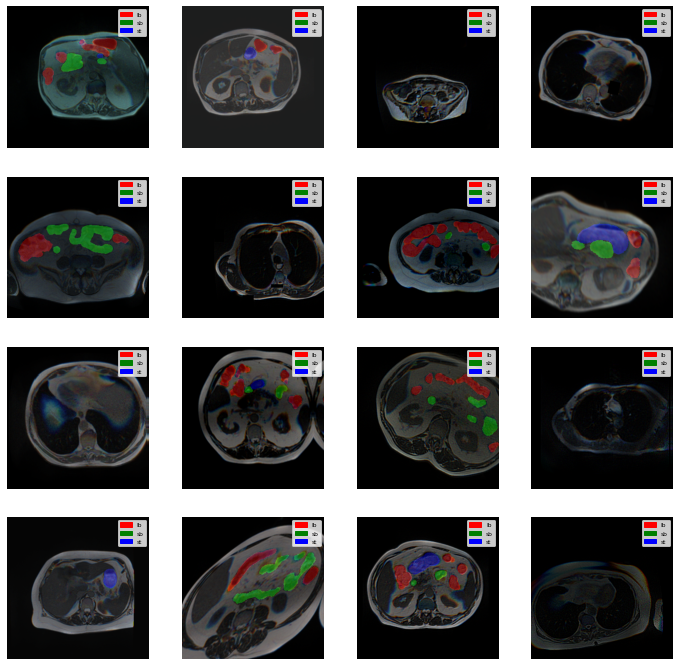

In [11]:
if not INFER:
    dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, show=True)

In [7]:
if not INFER:
    unet = smp.Unet(
        encoder_name='efficientnet-b0',      
        encoder_weights="imagenet",    
        in_channels=5,                 
        classes=3,       
        activation=None,
        )
    
    learn = get_custom_learner(dls, 
                               unet, 
                               # TverskyLoss(), 
                               ComboLoss(),
                               unet_splitter,
                               # opt_func=ranger,
                               cbs=[GradientAccumulation(32), 
                                # SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="test-model")
                                   ],
                               metrics = [
                                   AvgMetric(dice_coeff_adj),
                                   SkipEmptyMetric(dice_coeff_adj_skip),
                                   AvgMetric(hd_dist_adj),
                                   AvgMetric(hd_dist_adj_norm),
                                   SkipEmptyMetric(hd_dist_adj_skip),
                                   SkipEmptyMetric(hd_dist_adj_skip_norm),
                               ]
                              )
    
    # learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)
    # learn = get_custom_learner(dls, NestedUNet(3, 3, deep_supervision=True), deep_supervision_loss, splitter, metrics=[dice_coeff2, hd_dist2, custom_metric2])

In [8]:
# if not INFER:
#     learn = unet_learner(dls, resnet18, n_out=3, metrics=[dice_coeff, hd_dist, custom_metric], loss_func=BCEWithLogitsLossFlat()).to_fp16()

## exp-7-v2 + exp-9-v2

In [57]:
learn1 = load_learner('uwmadisonutils/exp-7-v2.1.pkl', cpu=False)
learn2 = load_learner('uwmadisonutils/exp-9-v2.pkl', cpu=False)

In [58]:
test_ensemble(learn1, learn2, 0.4)

100%|██████████| 246/246 [09:24<00:00,  2.29s/it]

model 1: 0.7018266349089354
model 2: 0.69584839509515
ensembles:
0.1 0.9 0.6971778667362183
0.2 0.8 0.6987794805500095
0.30000000000000004 0.7 0.7003519251201834
0.4 0.6 0.7058549094550548
0.5 0.5 0.7062719049419395
0.6000000000000001 0.3999999999999999 0.7117947364429187
0.7000000000000001 0.29999999999999993 0.7068584448510141
0.8 0.19999999999999996 0.7044415221493834
0.9 0.09999999999999998 0.7033536377123745


In [53]:
test_ensemble(learn1, learn2)

  0%|          | 0/246 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
100%|██████████| 246/246 [09:22<00:00,  2.29s/it]

model 1: 0.7008302604415786
model 2: 0.6951591626239004
ensembles:
0.1 0.9 0.6963371260209874
0.2 0.8 0.6978260878507819
0.30000000000000004 0.7 0.7002647273413317
0.4 0.6 0.7017877628377248
0.5 0.5 0.7117490130296155
0.6000000000000001 0.3999999999999999 0.7074504272613155
0.7000000000000001 0.29999999999999993 0.7048447087940026
0.8 0.19999999999999996 0.7038308581638416
0.9 0.09999999999999998 0.7024289983440352


## Training

In [9]:
if not INFER:
    learn.lr_find()

In [10]:
lr = 1e-3

In [11]:
if not INFER:
    learn.fine_tune(10, lr, lr_mult=400)

In [12]:
# if not INFER:
#     learn.unfreeze()
#     learn.fit_one_cycle(10, slice(lr/400, lr/10))

## Show Results

In [13]:
if not INFER:
    learn.show_results(max_n=16)

## Save Model

In [14]:
if not INFER:
    learn.export(model_name)

## Test inference 

In [74]:
if INFER:
    learn = load_learner(model_name, cpu=False)

## Visualize inference

In [111]:
if DEBUG and VIZ:
    # dls, dev = get_dls(train, sample=True, frac=0.5, show=False)
    dls, dev = get_5C_25D_dls(train, bs=16, up_size=(320, 384), crop=0.9, sample=True, sample_empty=True, frac=0.1, show=False)
    
    # raw_dl = dls.valid.new(after_item=[ToTensor], after_batch=[], bs=1)

    imgs, preds, targs = learn.get_preds(dl=dls.valid, with_input=True)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [112]:
if DEBUG and VIZ:
    preds_masks = (sigmoid(preds[-1]) > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

In [189]:
def unpad_img(img, org_size):
    shape0 = np.array(org_size)
    resize = np.array(img.shape[:2])
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        
        if pady[0] != 0:
            img = img[pady[0]:-pady[1], :, :]
            
        if padx[0] != 0:
            img = img[:, padx[0]:-padx[1], :]
            
        img = img.reshape((*shape0, img.shape[-1]))
    return img

def pad_img(img, up_size=None):
    if up_size is None:
        return img
    shape0 = np.array(img.shape[:2])
    resize = np.array(up_size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        padz = [0, 0]
        img = np.pad(img, [pady, padx, padz])
        img = img.reshape((*resize, img.shape[-1]))
    return img

def resize_img_to_org_size(img, org_size):
    shape0 = np.array(img.shape[:2])
    diff = org_size - shape0
    if np.any(diff < 0):
        img = pad_img(img, (320, 384))
        resized = unpad_img(img, org_size)
    else:
        resized = pad_img(img, org_size)
    return resized

In [190]:
if DEBUG and VIZ:
    before_dices = []
    after_dices = []
    org_imgs = []
    inp_masks = []
    targ_masks = []
    val = dev.query('is_valid')
    i = 0
    for pred_mask, pred, targ, width, height in tqdm(zip(preds_masks, preds[-1], targs, val['slice_w'], val['slice_h'])):
        # upsized_mask = np.moveaxis(cv2.resize(pred_mask, dsize=(height, width), interpolation=cv2.INTER_CUBIC), -1, 0)
        
        resized_mask = np.moveaxis(resize_img_to_org_size(pred_mask, (height, width)), -1, 0)
        
        targ_mask = image2tensor(PILImage.create(get_mask(val.iloc[i])))/255
        org_img = TensorImage(image2tensor(get_25D_image(val.iloc[i])))
        
        before_dices.append(dice_coeff_adj_pp(pred[None, ...], targ[None, ...]))
        after_dices.append(dice_coeff_adj_pp(resized_mask[None, ...], targ_mask[None, ...]))
        org_imgs.append(org_img)
        inp_masks.append(resized_mask)
        targ_masks.append(targ_mask)
        
        i+=1

764it [02:39,  4.80it/s]


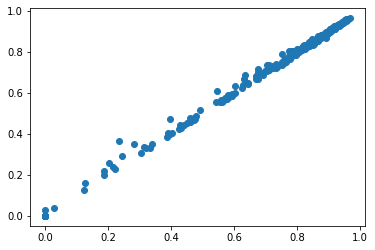

In [191]:
if DEBUG and VIZ:
    diff = abs(np.array(before_dices) - np.array(after_dices))
    diff_idx_sorted = np.argsort(diff)[::-1]

    plt.scatter(before_dices, after_dices);

In [192]:
if DEBUG and VIZ: print(np.mean([s for s in before_dices if s != 0]), np.mean([s for s in after_dices if s != 0]))

0.7833152879348918 0.7845563472388374


In [193]:
def plt_before_after(idx):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    
    print(before_dices[idx], after_dices[idx], val.iloc[idx]['slice_h'], val.iloc[idx]['slice_w'])
    
    # plot image and target before upsize
    decoded_small_img, decoded_small_mask = dls.decode((imgs[idx], targs[idx]))
    
    if decoded_small_img.shape[-1] > 3:
        decoded_small_img = decoded_small_img[:, [1, 2, 3], :]
        org_img = org_imgs[idx][[1, 2, 3], :, :]
        
    else:
        org_img = org_imgs[idx]
    
    show_image(decoded_small_img[0], cmap='gray', ctx=axes[0])
    show_image(decoded_small_mask, cmap='Spectral_r', alpha=0.35, ctx=axes[0], title="Target (Model size)")
    
    # plot image and pred before upsize
    show_image(decoded_small_img[0], cmap='gray', ctx=axes[1])
    show_image(preds_masks[idx]*255, cmap='Spectral_r', alpha=0.35, ctx=axes[1], title="Prediction (Model size)")
    
    # plot image and target after upsize
    show_image(org_img, ctx=axes[2])
    show_image(targ_masks[idx], cmap='Spectral_r', alpha=0.35, ctx=axes[2], title="Target (original)")
    
    # plot image and pred after upsize
    show_image(org_img, ctx=axes[3])
    show_image(np.moveaxis(inp_masks[idx], 0, -1)*255, cmap='Spectral_r', alpha=0.35, ctx=axes[3], title="Prediction (upsized)")

0.5456123994092407 0.6078440440573661 266 266


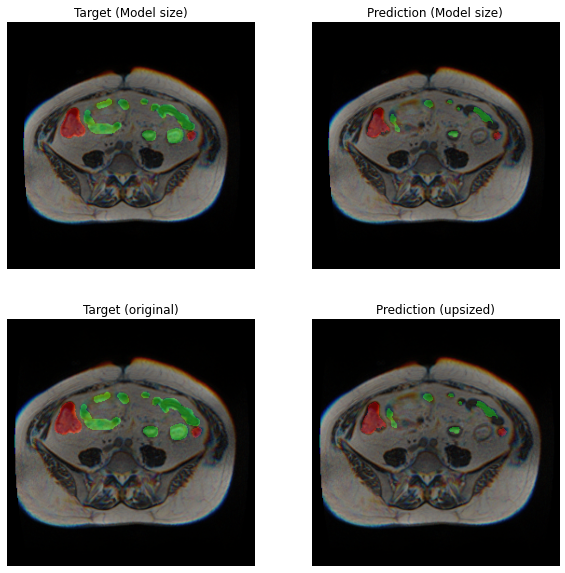

In [194]:
if DEBUG and VIZ: plt_before_after(diff_idx_sorted[3])

In [195]:
def get_gt_count(rle):
    if isinstance(rle, str):
        return np.sum([int(x) for i, x in enumerate(rle.split(' '), 1) if i % 2 == 0])
    else:
        return 0
    
    
train['slice_no'] = train['slice_id'].apply(lambda x: int(x.split('_')[1].lstrip('0')))
test['slice_no'] = test['slice_id'].apply(lambda x: int(x.split('_')[1].lstrip('0')))

train.pixels_count = train.slice_w * train.slice_h

train['lb_seg_count'] = train.lb_seg_rle.apply(get_gt_count)
train['sb_seg_count'] = train.sb_seg_rle.apply(get_gt_count)
train['st_seg_count'] = train.st_seg_rle.apply(get_gt_count)

train['lb_seg_prop'] = train.lb_seg_count/train.pixels_count
train['sb_seg_prop'] = train.sb_seg_count/train.pixels_count
train['st_seg_prop'] = train.st_seg_count/train.pixels_count

train['lb_seg_flag'] = train['lb_seg_flag'].astype(int)
train['sb_seg_flag'] = train['sb_seg_flag'].astype(int)
train['st_seg_flag'] = train['st_seg_flag'].astype(int)

test['lb_seg_flag'] = test['lb_seg_flag'].astype(int)
test['sb_seg_flag'] = test['sb_seg_flag'].astype(int)
test['st_seg_flag'] = test['st_seg_flag'].astype(int)

prop_thresh = train.groupby('slice_no')[['lb_seg_prop', 'sb_seg_prop', 'st_seg_prop']].mean()
lb_zero = [1, 138, 139, 140, 141, 142, 143, 144]
sb_zero = [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 138, 139, 140, 141, 142, 143, 144]
st_zero = [1, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]

In [196]:
if INFER:
    bs = 24
    test_dl = learn.dls.test_dl(test, bs=bs, shuffle=False).to('cuda')
    b = test_dl.one_batch()

In [197]:
def mask2rle(mask):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    mask = np.array(mask)
    pixels = mask.flatten()
    pad = np.array([0])
    pixels = np.concatenate([pad, pixels, pad])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return " ".join(str(x) for x in runs)

def get_rle_masks(preds, df):
    rle_masks = []
    for pred, width, height in zip(preds, df['slice_w'], df['slice_h']):
        upsized_mask = resize_img_to_org_size(pred, (height, width))
        for i in range(3):
            rle_mask = mask2rle(upsized_mask[:, :, i])
            rle_masks.append(rle_mask)
    return rle_masks

In [198]:
def post_process(inp, slice_no):
    if inp.shape[-1] != 3: 
        sum_dims = (2, 3)
    else:
        sum_dims = (1, 2)
        
    pixels_count = inp.shape[sum_dims[0]] * inp.shape[sum_dims[1]]
    
    inp[np.where(inp.sum(sum_dims)/pixels_count < prop_thresh.loc[slice_no].values)] = 0
    
    return inp

In [199]:
if INFER:
    learn.model = learn.model.cuda()
    learn.model.eval()
    masks = []
    
    with torch.no_grad():
        for i, b in enumerate(tqdm(test_dl)):
            b.to('cuda')
            b_preds = (sigmoid(learn.model(b)[-1]) > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

            b_preds = post_process(b_preds, test.iloc[i*bs:i*bs+bs]['slice_no'].values)
            masks.extend(get_rle_masks(b_preds, test.iloc[i*bs:i*bs+bs]))

            # test_preds[i*bs:i*bs+bs] = b_preds
            del b_preds
            torch.cuda.empty_cache()
            gc.collect()

    # Post process predictions
    # test_preds = post_process(test_preds)

100%|██████████| 42/42 [00:38<00:00,  1.08it/s]


In [201]:
# if INFER:
#     learn.model = learn.model.cuda()
#     test_dl = learn.dls.test_dl(test, shuffle=False).to('cuda')
#     test_preds = get_preds(learn, test_dl)

In [202]:
# if INFER:
#     masks = get_rle_masks(test_preds, test)   

In [203]:
remove_seg_slices = {
     "large_bowel": [1, 138, 139, 140, 141, 142, 143, 144],
    "small_bowel": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 138, 139, 140, 141, 142, 143, 144],
    "stomach": [1, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
}


def fix_empty_slices(_row):
    if _row['slice_no'] in remove_seg_slices[_row["class"]]:
        _row["predicted"] = ""
    return _row

def get_case_id(fname):
    if KAGGLE: i = 5
    elif GRADIENT: i = 2
    return fname.parts[i] + '_' + fname.parts[i+2][:10]

In [204]:
if INFER:
    submission = pd.DataFrame({
        'id': chain.from_iterable([[get_case_id(fname)]*3 for fname in test['fname']]),
        'class': chain.from_iterable([['large_bowel', 'small_bowel', 'stomach'] for _ in test['fname']]),
        'slice_no': chain.from_iterable([[slice_no]*3 for slice_no in test['slice_no']]),
        'predicted': masks,
    })
    
    submission = submission.apply(fix_empty_slices, axis=1)
    del submission['slice_no']
    
    if sample_submission.shape[0] > 0:
        del sample_submission['segmentation']
        
        submission = sample_submission.merge(submission, on=['id', 'class'])
        
    
    submission.to_csv('submission.csv', index=False)